In [1]:
#Get Ensembl ID to genelist
import pandas as pd
import gzip
import re

# 1.read files
gtf_path = "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/ref/Homo_sapiens.GRCh38.84.gtf.gz"
mapping = {}

with gzip.open(gtf_path, "rt") as f:
    for line in f:
        if line.startswith("#"):
            continue
        fields = line.strip().split('\t')
        if fields[2] == "gene":
            attr = fields[8]
            gid = re.search(r'gene_id "([^"]+)"', attr)
            gname = re.search(r'gene_name "([^"]+)"', attr)
            if gid and gname:
                mapping[gid.group(1)] = gname.group(1)

# 2. get genelist
def annotate_gene_list(infile, outfile, mapping):
    with open(infile) as fin, open(outfile, "w") as fout:
        fout.write("gene_id\tgene_name\n")
        for line in fin:
            gene_id = line.strip()
            gene_name = mapping.get(gene_id, "NA")
            fout.write(f"{gene_id}\t{gene_name}\n")

# 3. annotation
for sid in ["SRR9900120", "SRR9900121", "SRR9900122"]:
    infile = f"/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/mtRNA_bound_genes_{sid}.txt"
    outfile = f"/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/mtRNA_bound_genes_{sid}_annotated.txt"
    annotate_gene_list(infile, outfile, mapping)
    print(f"Annotated file saved: {outfile}")


Annotated file saved: /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/mtRNA_bound_genes_SRR9900120_annotated.txt
Annotated file saved: /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/mtRNA_bound_genes_SRR9900121_annotated.txt
Annotated file saved: /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/mtRNA_bound_genes_SRR9900122_annotated.txt


In [8]:
#Function Enrichment analysis

import gseapy as gp
import pandas as pd
import os

# Define your sample names and paths
samples = ["SRR9900120", "SRR9900121", "SRR9900122"]
input_dir = "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis"
outdir = os.path.join(input_dir, "enrichr_results")
os.makedirs(outdir, exist_ok=True)

for sid in samples:
    print(f"Processing {sid}...")
    gene_file = os.path.join(input_dir, f"mtRNA_bound_genes_{sid}_annotated.txt")
    
    # Read the annotated genelist
    df = pd.read_csv(gene_file, sep="\t")
    
    # Remove "NA" and duplicate gene names
    gene_names = df["gene_name"].dropna().unique().tolist()
    gene_names = [g for g in gene_names if g != "NA"]
    
    # Skip samples with too few genes
    if len(gene_names) < 10:
        print(f"{sid}: Too few genes for enrichment ({len(gene_names)}), skipping...")
        continue

    # Run enrichment analysis using Enrichr gene sets: GO BP, KEGG, Reactome
    enr = gp.enrichr(
        gene_list=gene_names,
        gene_sets=['GO_Biological_Process_2021', 'KEGG_2021_Human', 'Reactome_2022'],
        organism='Human',
        outdir=os.path.join(outdir, sid), # Save each sample's results in a separate folder
        cutoff=0.05 # Only show terms with FDR < 0.05
)

    # Save the enrichment results as CSV
    enr.results.to_csv(os.path.join(outdir, sid, f"{sid}_enrichr_results.csv"), index=False)

    # Save a barplot of the top 20 enrichment terms
    gp.barplot(enr.results, title=f'{sid} GO Enrichment', top_term=20,
               ofname=os.path.join(outdir, sid, f"{sid}_GO_enrichment_barplot.png"))
    
    print(f"{sid} enrichment done! Results saved in {os.path.join(outdir, sid)}")

# To view results for one sample in notebook:
sid = "SRR9900120"
csv_file = f"/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/enrichr_results/{sid}/{sid}_enrichr_results.csv"
df = pd.read_csv(csv_file)
display(df.head(10))

Processing SRR9900120...
SRR9900120 enrichment done! Results saved in /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/enrichr_results/SRR9900120
Processing SRR9900121...
SRR9900121 enrichment done! Results saved in /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/enrichr_results/SRR9900121
Processing SRR9900122...
SRR9900122 enrichment done! Results saved in /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis/enrichr_results/SRR9900122


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,cellular protein modification process (GO:0006...,721/1025,1.252534e-17,7.540254e-14,0,0,1.780260,69.285539,GMFB;PGAP1;GMFG;TESK2;DCAF8;DCAF5;DCAF4;DCAF6;...
1,GO_Biological_Process_2021,protein phosphorylation (GO:0006468),372/496,4.487712e-16,1.350801e-12,0,0,2.229889,78.804324,APP;GMFB;TP53RK;GMFG;TESK2;RPS6KA4;LIPE;PPP4R1...
2,GO_Biological_Process_2021,regulation of intracellular signal transductio...,328/437,2.083921e-14,4.181735e-11,0,0,2.231965,70.311229,RPL5;TRIO;TP53RK;EHMT2;ITSN1;ULK4;EHMT1;NOC2L;...
3,GO_Biological_Process_2021,phosphorylation (GO:0016310),297/400,3.371767e-12,5.074509e-09,0,0,2.134396,56.381310,APP;PANK2;GMFB;CERK;TP53RK;GMFG;TESK2;RPS6KA4;...
4,GO_Biological_Process_2021,peptidyl-serine phosphorylation (GO:0018105),130/156,6.757607e-12,8.136158e-09,0,0,3.680665,94.667999,RPS6KA4;TBK1;AKT2;RPS6KA2;RPS6KA1;AKT1;PDK3;ST...
5,GO_Biological_Process_2021,protein autophosphorylation (GO:0046777),129/159,3.137489e-10,3.147947e-07,0,0,3.163590,69.227036,MYLK2;IGF1R;STK10;STK11;SLK;CHEK2;STK16;KDR;PI...
6,GO_Biological_Process_2021,DNA metabolic process (GO:0006259),207/277,2.504996e-09,2.014045e-06,0,0,2.180154,43.177899,SMARCAL1;SMARCB1;TRRAP;NUDT1;BACH1;ALKBH3;ENDO...
7,GO_Biological_Process_2021,peptidyl-serine modification (GO:0018209),134/169,2.676472e-09,2.014045e-06,0,0,2.816309,55.590458,GALNT13;POGLUT1;GALNT16;RPS6KA4;TBK1;AKT2;RPS6...
8,GO_Biological_Process_2021,transmembrane receptor protein tyrosine kinase...,289/404,5.509328e-09,3.685128e-06,0,0,1.856187,35.298786,CYFIP2;EPHB6;CYFIP1;NCKAP1;ITSN1;SOGA1;FGFRL1;...
9,GO_Biological_Process_2021,cellular response to DNA damage stimulus (GO:0...,253/350,1.034973e-08,6.230540e-06,0,0,1.924525,35.384910,ATF2;SMARCAL1;CCNK;TRRAP;NUDT1;SMC5;SMC6;BACH1...


Genes in ALL samples: 7429
Unique to SRR9900120: 1094
Unique to SRR9900121: 1451
Unique to SRR9900122: 1648
Shared by SRR9900120 & SRR9900121 only: 1453
Shared by SRR9900120 & SRR9900122 only: 1584
Shared by SRR9900121 & SRR9900122 only: 2429


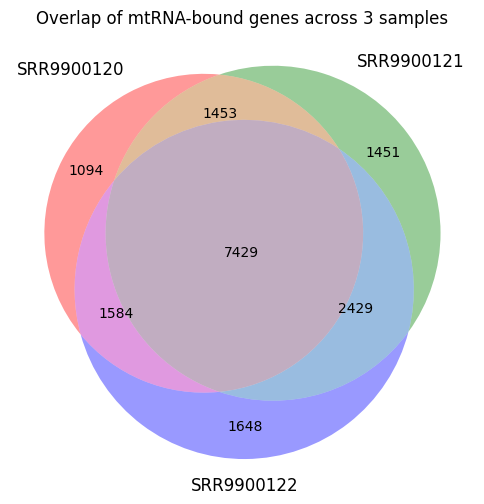

In [2]:
#Venn plot

import pandas as pd
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Define your sample IDs and corresponding gene list files
sample_ids = ["SRR9900120", "SRR9900121", "SRR9900122"]
input_dir = "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/analysis"

# Read each sample's gene_name list as a Python set
gene_sets = {}
for sid in sample_ids:
    file_path = f"{input_dir}/mtRNA_bound_genes_{sid}_annotated.txt"
    # Read gene_name column, skipping NA values
    df = pd.read_csv(file_path, sep="\t")
    genes = set(df.loc[df["gene_name"] != "NA", "gene_name"])
    gene_sets[sid] = genes

# Extract sets for easy access
set1, set2, set3 = gene_sets[sample_ids[0]], gene_sets[sample_ids[1]], gene_sets[sample_ids[2]]

# Calculate overlap and unique gene sets
common_genes = set1 & set2 & set3              # Genes in all three samples
unique_0 = set1 - set2 - set3                  # Only in sample 0
unique_1 = set2 - set1 - set3                  # Only in sample 1
unique_2 = set3 - set1 - set2                  # Only in sample 2
overlap_01 = (set1 & set2) - set3              # In 0 & 1 only
overlap_02 = (set1 & set3) - set2              # In 0 & 2 only
overlap_12 = (set2 & set3) - set1              # In 1 & 2 only

# Print summary statistics
print(f"Genes in ALL samples: {len(common_genes)}")
print(f"Unique to {sample_ids[0]}: {len(unique_0)}")
print(f"Unique to {sample_ids[1]}: {len(unique_1)}")
print(f"Unique to {sample_ids[2]}: {len(unique_2)}")
print(f"Shared by {sample_ids[0]} & {sample_ids[1]} only: {len(overlap_01)}")
print(f"Shared by {sample_ids[0]} & {sample_ids[2]} only: {len(overlap_02)}")
print(f"Shared by {sample_ids[1]} & {sample_ids[2]} only: {len(overlap_12)}")

# Save gene sets to files if needed
pd.Series(sorted(common_genes)).to_csv(f"{input_dir}/mtRNA_common_genes.txt", index=False, header=False)
pd.Series(sorted(unique_0)).to_csv(f"{input_dir}/mtRNA_unique_{sample_ids[0]}.txt", index=False, header=False)
pd.Series(sorted(unique_1)).to_csv(f"{input_dir}/mtRNA_unique_{sample_ids[1]}.txt", index=False, header=False)
pd.Series(sorted(unique_2)).to_csv(f"{input_dir}/mtRNA_unique_{sample_ids[2]}.txt", index=False, header=False)

# Venn diagram visualization
plt.figure(figsize=(6, 6))
venn3([set1, set2, set3], set_labels=sample_ids)
plt.title("Overlap of mtRNA-bound genes across 3 samples")

# Save the plot to file
output_path = f"{input_dir}/mtRNA_bound_genes_venn.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()


In [1]:
import gzip
import pandas as pd

pairs_file = "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/final_SRR9900120.pairs.gz"  # 输入 .pairs.gz 文件
output_bed = "/projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/SRR9900120_DNAend_100bp.bed"  # 输出扩展DNA-end后的 BED 文件

regions = []
with gzip.open(pairs_file, "rt") as f:
    for line in f:
        if line.startswith("#"):  # 跳过注释行
            continue
        fields = line.strip().split("\t")
        chrom = fields[3]      # DNA-end 染色体 = 第4列
        pos = int(fields[4])   # DNA-end 坐标 = 第5列
        start = max(0, pos - 100)
        end = pos + 100
        regions.append((chrom, start, end))

# 去重并排序
df = pd.DataFrame(regions, columns=["chrom", "start", "end"])
df = df.drop_duplicates().sort_values(["chrom", "start", "end"])

df.to_csv(output_bed, sep="\t", index=False, header=False)
print(f"[INFO] 保存 BED 文件: {output_bed}, 共 {len(df)} 个区域")


[INFO] 保存 BED 文件: /projectnb/perissilab/Xinyu/GPS2_CHIPseq/iMargi/output/SRR9900120_DNAend_100bp.bed, 共 13735496 个区域
